# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [150]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



In [151]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [152]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

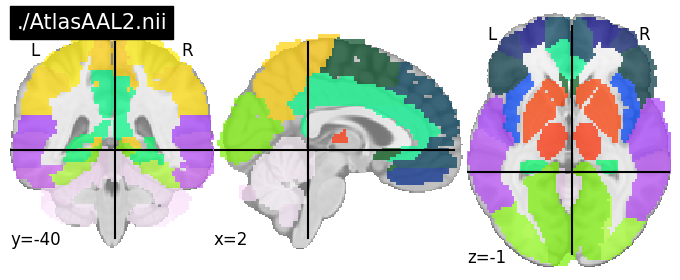

In [153]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [154]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

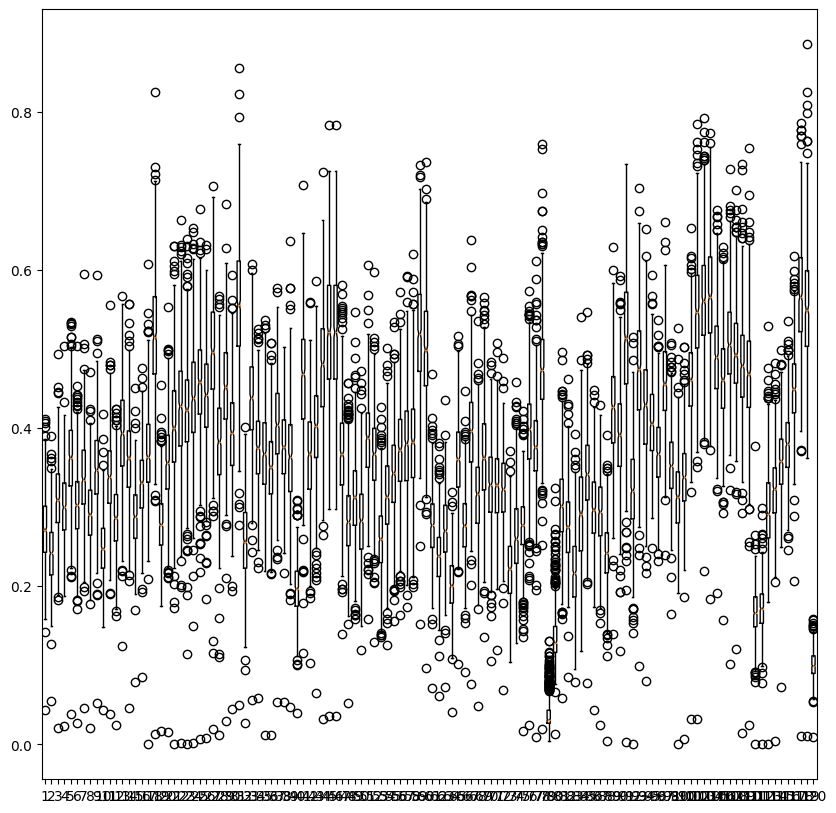

In [155]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(X_train, y_train);
scaler.transform(X_test);

Then, we can fit a Decision tree, with the default setting, using the following code:

In [156]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7682119205298014


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 




**Answer:** 

When tuning hyperparameters for a machine learning model, it is important to use a metric that reflects the model's ability to generalize to new, unseen data, since the ultimate goal of the model is to make accurate predictions on new data that it has not seen before. By maximizing the test score, we aim to find the hyperparameters that produce the best generalization performance for the model. Therefore, we use the test score of 'min_samples_split' and 'min_samples_leaf' as the primary metric for evaluation.  

Spliting differently the data will result in different observations being assigned to the training and testing sets, which can in turn affect the performance of the model. However, the choice of random_state does not have an important effect on the quality of the model, as long as the training and testing sets are representative of the overall data and are large enough to provide accurate estimates.





The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  3


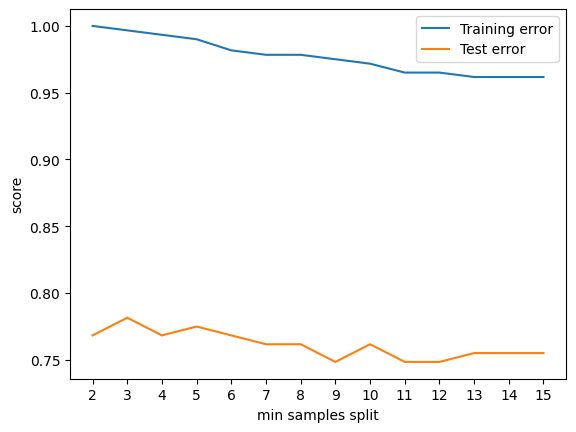

In [157]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

best_min_samples_split = TTest.index(max(TTest))+2

The value of min_samples_leaf that maximizes the training score is :  1
The value of min_samples_leaf that maximizes the test score is :  1


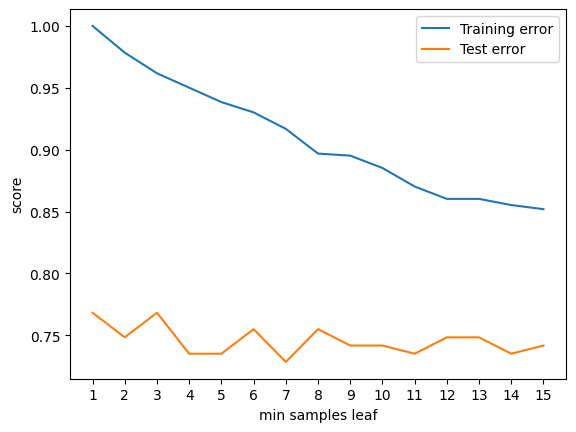

In [158]:
# min_samples_leaf

TTest=[]
TTrain=[]
for i in range(1,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(15), ('1', '2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+1)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(15), ('1', '2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples leaf')
plt.ylabel('score')
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+1)
plt.legend();

best_min_samples_leaf = TTest.index(max(TTest))+1


Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer:** As it is possible to observe below the results are not stable at all. In most cases, the addition of noise result in a score smaller than the score of the original test set without noise.

The application of an unique Decision tree without any ensemble method generally implies in a model more sensitive to noise, depending on the amount of noise and on which attributes are noisy. A decision tree uses a small subset of attributes for classification in such way that the presence of noise in these attributes causes inconsistencies that lead to a considerable downgrade of the classification performance.

Indeed, some studies have shown that, in general, learners relaint on more attributes tend to be more robust. However, this is not always the case, as Naive Bayes and Logistic Regression are not robust [2].

**Reference**:
[2] Abbasian, H., Drummond, C., Japkowicz, N. and Matwin, S., 2010, May. Robustness of Classifiers to Changing Environments. In Canadian Conference on AI (pp. 232-243).

---



Text(0.5, 1.0, 'Decision Tree')

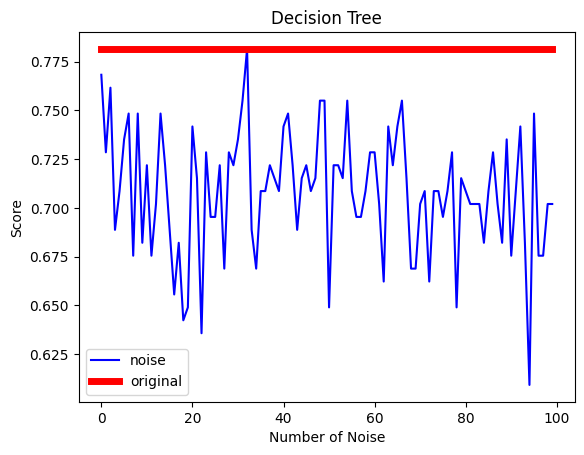

In [159]:
Tree = DecisionTreeClassifier(min_samples_split=best_min_samples_split,min_samples_leaf=best_min_samples_leaf,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)

for k in range(100):    
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] = X_train[i] + np.abs(np.random.normal(0,0.05,X_train.shape[1]))
    
    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();
plt.xlabel('Number of Noise')
plt.ylabel('Score')
plt.title('Decision Tree')

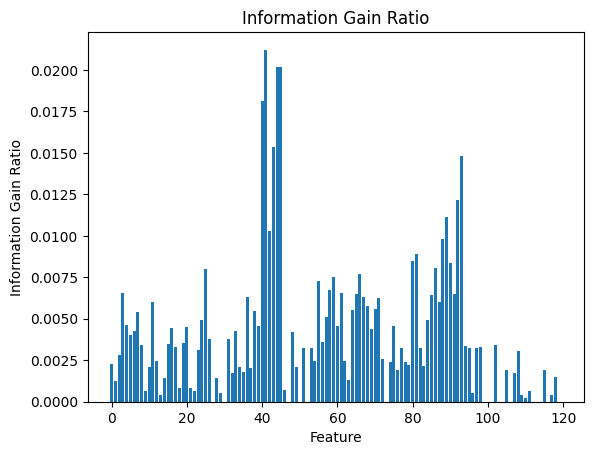

[43 40 45 44 41]
[0.01533723 0.0181185  0.0202032  0.0202032  0.02121765]


In [160]:
from sklearn.feature_selection import mutual_info_classif

def calculate_information_gain_ratio(X, y):
    mutual_info = mutual_info_classif(X, y)
    entropy = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        _, counts = np.unique(X[:, i], return_counts=True)
        probs = counts / counts.sum()
        entropy[i] = -np.sum(probs * np.log2(probs))
    return mutual_info / entropy

ig = calculate_information_gain_ratio(X, y.ravel())

plt.bar([x for x in range(len(ig))], ig)
plt.title('Information Gain Ratio')
plt.xlabel('Feature')
plt.ylabel('Information Gain Ratio')
plt.show()

print(np.argsort(ig)[-5:])
print(ig[np.argsort(ig)[-5:]])

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

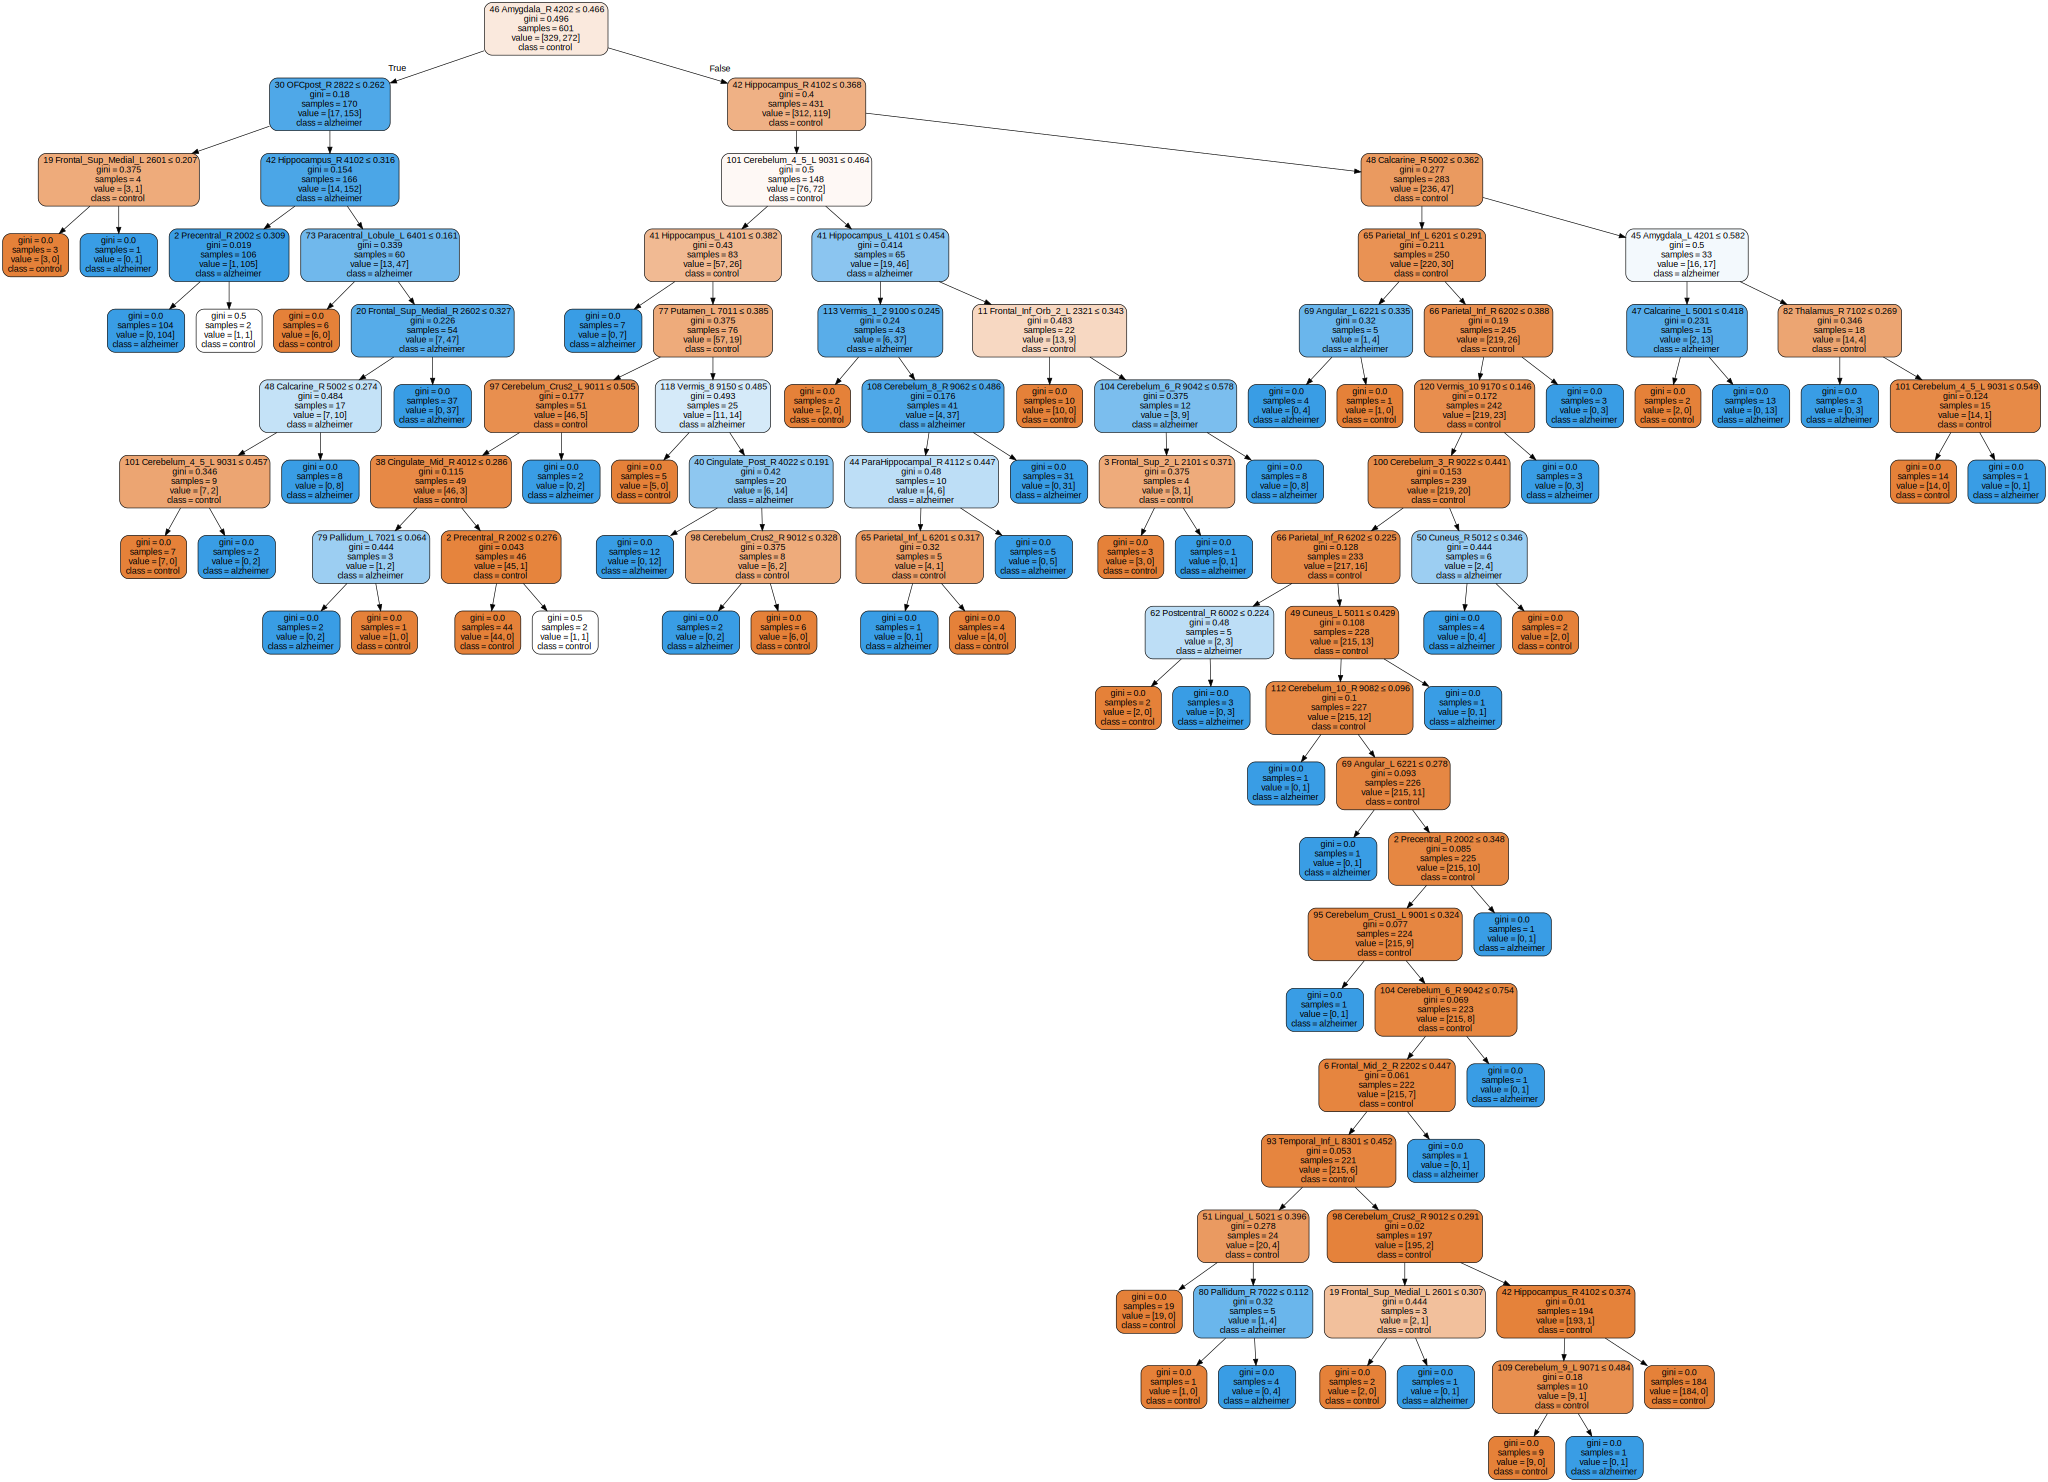

In [161]:
import graphviz 

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("tree")
graph

# tree.export_graphviz(Tree, out_file='tree.dot',feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True,max_depth=4)
# import os
# os.system('dot -Tpdf tree.dot -o tree.pdf')


Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

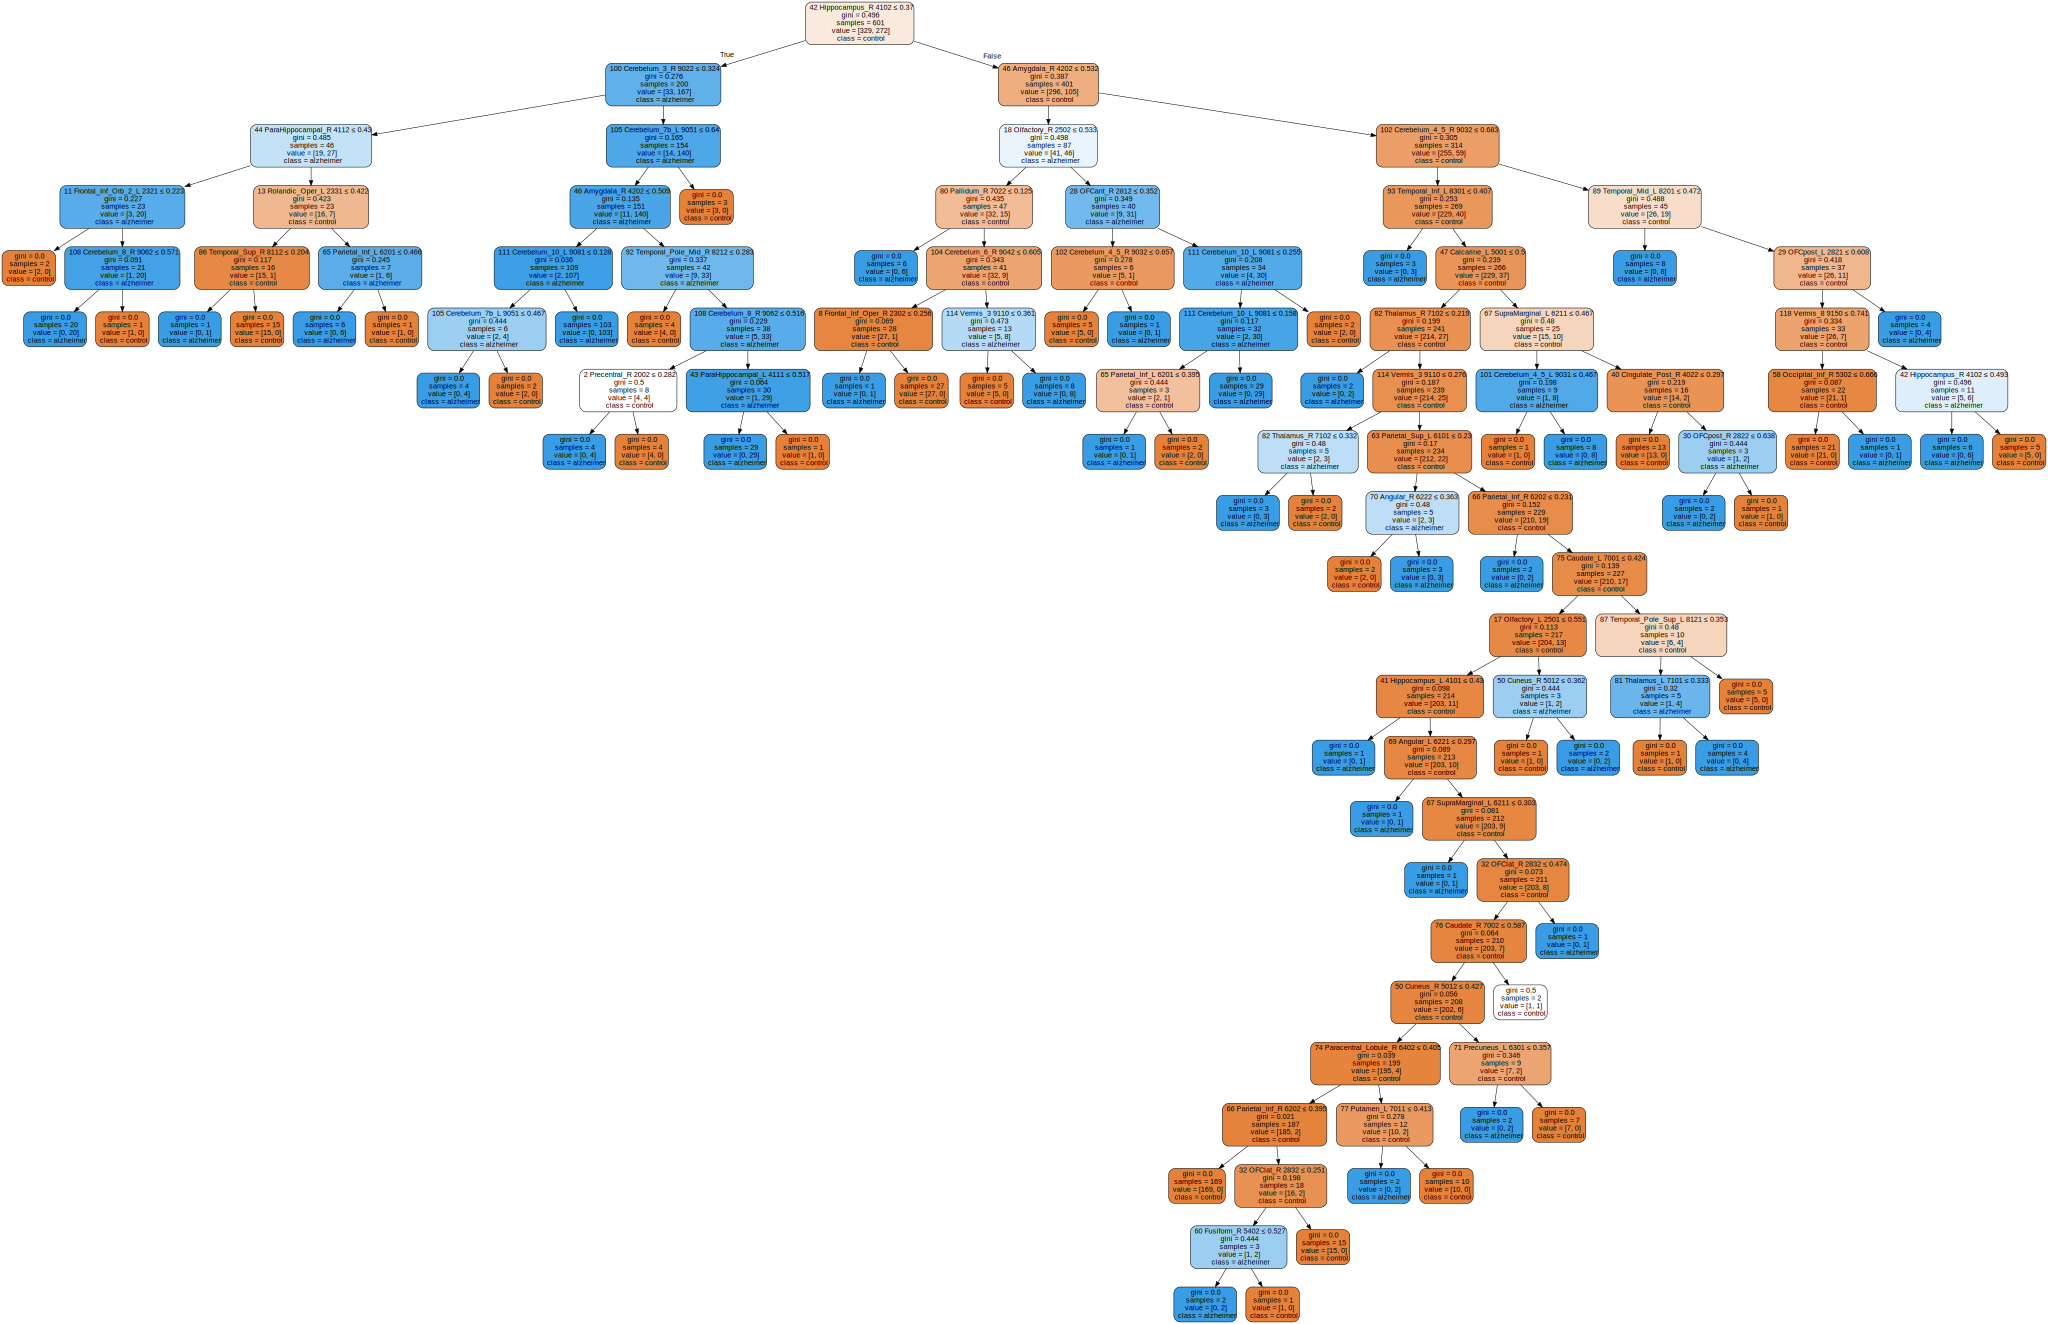

In [162]:
Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

# tree.export_graphviz(Tree, out_file='tree.dot',feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True,max_depth=4)
# import os
# os.system('dot -Tpdf tree.dot -o tree.pdf')

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer:** 

The hyperparameter are not the same since the methods for hyperparameter tuning applied are not the same. The GridSearchCV performs an exhaustive search over a predefined hyperparameter space, defined using a dictionary of hyperparameter values (in this case 'min_samples_split' and 'min_samples_leaf'), evaluating the performance of the model using each combination of hyperparameters in the space and returning the best combination based on a metric (in the cases above: 'accuracy'). 

Previously, a search was conducted to identify the optimal parameters separately based on their performance on the test set. However, this approach may not necessarily yield the best combination of parameters.

Concerning the scoring method, as seen in the previous PW, accuracy is not a good metric for problems with different costs for misclassification between classes as in a medical problem. Recall is more useful when the cost of false negative predictions is higher.

In [163]:
Tree = DecisionTreeClassifier(min_samples_split=best_min_samples_split,min_samples_leaf=best_min_samples_leaf,random_state=0)
p_grid_tree = {'min_samples_split': np.arange(2, 16),'min_samples_leaf': np.arange(1, 16)}
grid_tree = GridSearchCV(Tree, p_grid_tree, cv=5, return_train_score=True)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7720936639118456
Best params: {'min_samples_leaf': 10, 'min_samples_split': 2}
Tree test score : 0.7417218543046358


In [164]:
# with noisy data 

Tree = DecisionTreeClassifier(min_samples_split=best_min_samples_split,min_samples_leaf=best_min_samples_leaf,random_state=0)
p_grid_tree = {'min_samples_split': np.arange(2, 16),'min_samples_leaf': np.arange(1, 16)}
grid_tree = GridSearchCV(Tree, p_grid_tree, cv=5, return_train_score=True)
grid_tree.fit(X_train_temp, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7386914600550964
Best params: {'min_samples_leaf': 5, 'min_samples_split': 14}
Tree test score : 0.6887417218543046


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer:** The trees obtained without noise present almost the same result changing just the result in the leaves. In the noisy data case, the tree changed a lot but it is possible to observe that some ROI's near to the root are the same, as the Hippocampus and the Amygdala. This may indicate that these ROI's are highly informative for distinguishing between the different classes. 



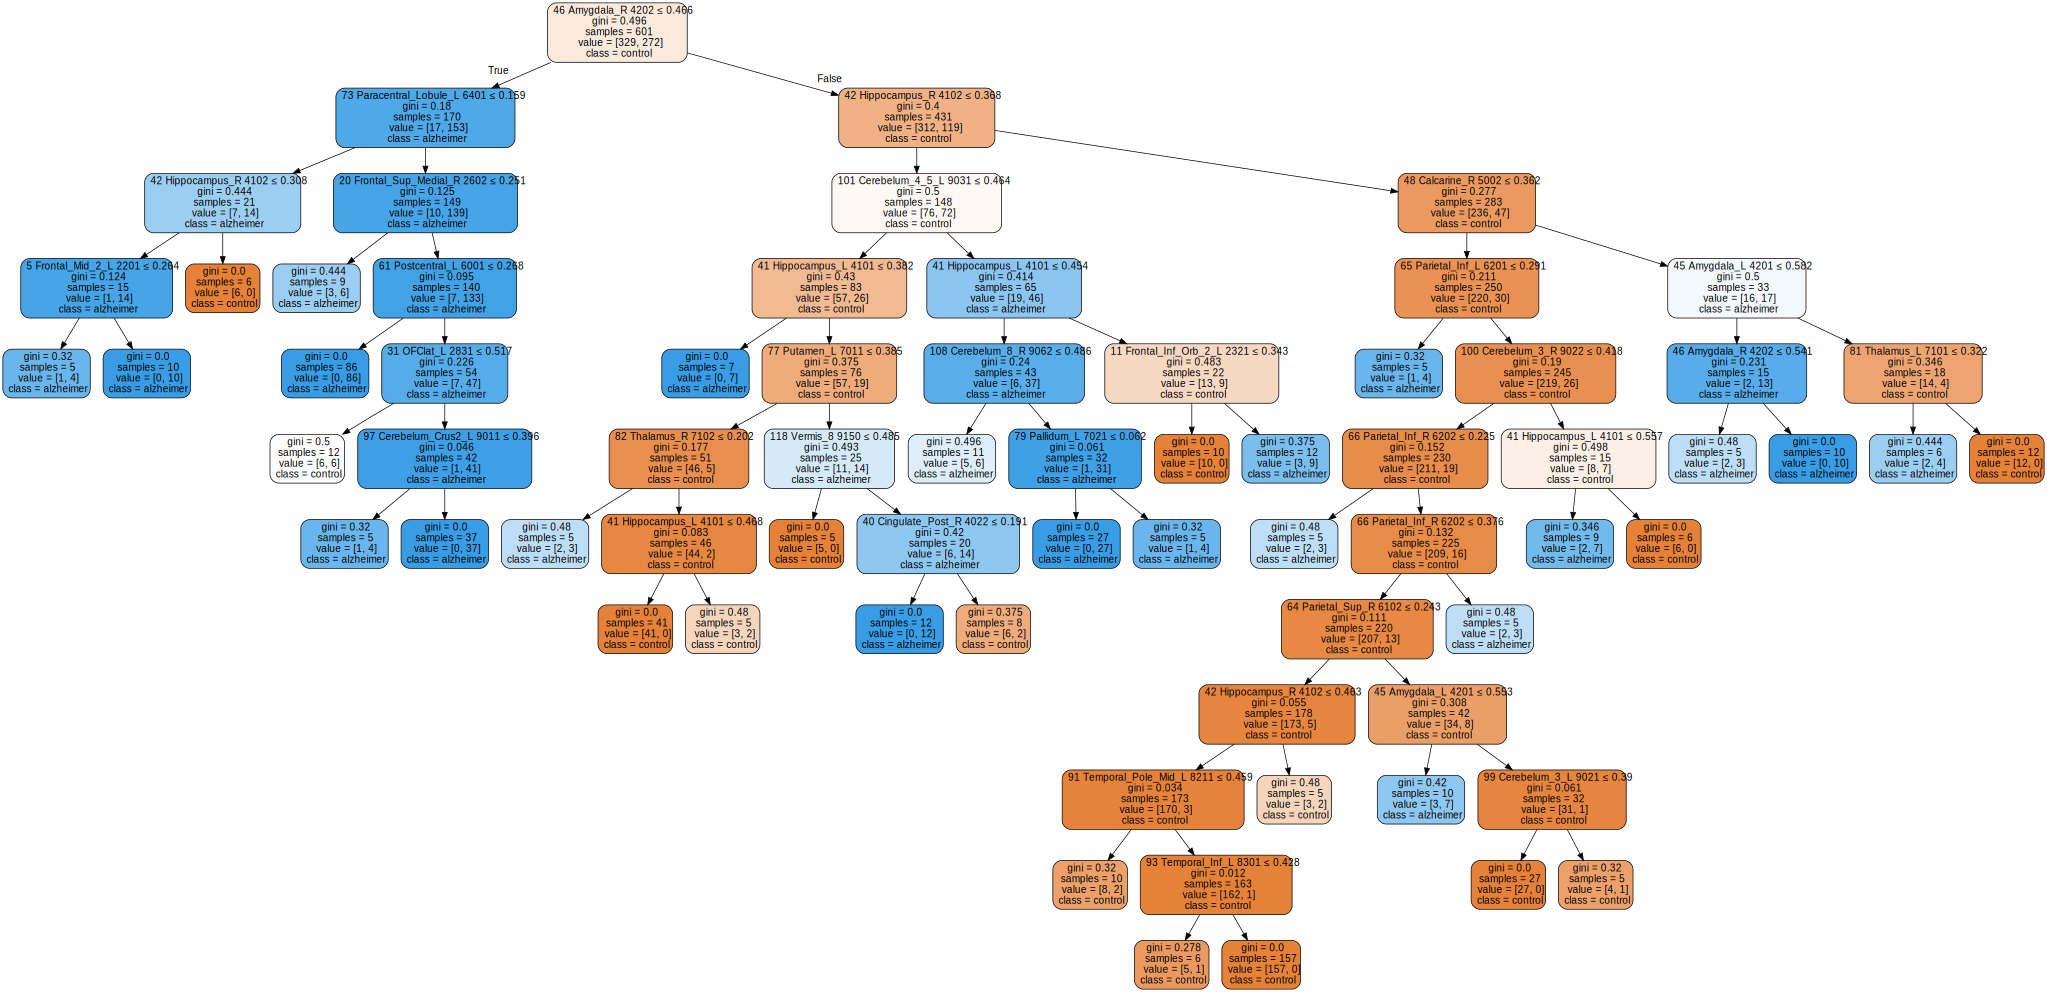

In [165]:
Tree = DecisionTreeClassifier(min_samples_split=best_params['min_samples_split'],min_samples_leaf=best_params['min_samples_leaf'],random_state=0)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

Numerous research studies have focused on the challenges associated with using ensembles of decision trees in domains with noisy data. These studies showed as  Bagging ensembles are the most robust and
outperforming ensembles in these situations [3]. The presence of noisy training data typically leads to increased variance in the predictions of classifiers and Bagging ensembles that utilize variance-reducing methods have been found to be effective [4].

Indeed, comparing the results with and without noise of both Bagging and Decision Trees, it is possible to observe that the performance of the model using Bagging with noise is better than the result of the Decision tree model in noisy data. The same  occurs in the absence of noise. These results are in line with the results presented in the study above [2] on the greater robustness of ensemble methods.


**Reference:** 

[3] Abellán, J. and Masegosa, A.R., 2012. Bagging schemes on the presence of class noise in classification. Expert Systems with Applications, 39(8), pp.6827-6837.

[4] Breiman, L., 1996. Bagging predictors. Machine learning, 24, pp.123-140.

In [166]:
y_train = y_train.ravel()   
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5, return_train_score=True)
grid_bagging.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.8219421487603306
Best params: {'n_estimators': 20}
Bagging test score : 0.7947019867549668


In [167]:
# Bagging on noisy data

Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5, return_train_score=True)
grid_bagging.fit(X_train_temp, y_train);
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.7720247933884298
Best params: {'n_estimators': 20}
Bagging test score : 0.7615894039735099


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [168]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, cv=5, return_train_score=True)
grid_RF.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test, y_test))

Best Validation Score: 0.8435537190082645
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 15}
Random Forest test score : 0.7947019867549668


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

In [169]:
# Random Forest on noisy data

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, cv=5, return_train_score=True)
grid_RF.fit(X_train_temp , y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))


Best Validation Score: 0.8052617079889807
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 30}
Random Forest test score : 0.7615894039735099


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.091696)
2. feature 41 representing 42 Hippocampus_R 4102
 (0.067816)
3. feature 44 representing 45 Amygdala_L 4201
 (0.064542)
4. feature 40 representing 41 Hippocampus_L 4101
 (0.052356)
5. feature 43 representing 44 ParaHippocampal_R 4112
 (0.042794)
6. feature 92 representing 93 Temporal_Inf_L 8301
 (0.038369)
7. feature 93 representing 94 Temporal_Inf_R 8302
 (0.025769)
8. feature 59 representing 60 Fusiform_R 5402
 (0.022091)
9. feature 89 representing 90 Temporal_Mid_R 8202
 (0.018635)
10. feature 69 representing 70 Angular_R 6222
 (0.018200)


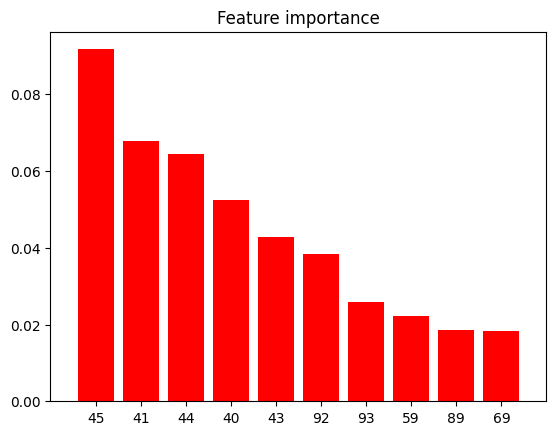

In [170]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

**Answer:** 

The research paper "The clinical use of structural MRI in Alzheimer disease" [5] indentifies medial temporal atrophy as a partially validated biomarker for early diagnosis of the Alzheimer diasease (AD) at the Mild Cognitive Impairment (MCI) stage. Rates of atrophy of the whole brain and hippocampus are highly sensitive and powerful markers of neurodegeneration progression.

The work of Rathore et al. also highlights the importance of the hippocampus, as well as the amygdala and temporal regions, empashizing that AD affects brain regions well beyond the
hippocampus, such as atrophy of the entorhinal cortex, , expansion of the ventricles and volumetric changes in other subcortical nuclei (amygdala, putamen,caudate, and thalamus) [6]. The authors conclude that the analysis of structures beyond the hippocampus may not only improve understanding of the spatial pattern of AD, but may also lead to a more
precise diagnosis.

Therefore, the feature ranking results make sense in the context of these two research papers, since the main features are the amygdala, hippocampus and temporal regions. 

**Reference:** 

[5] Frisoni, G.B., Fox, N.C., Jack Jr, C.R., Scheltens, P. and Thompson, P.M., 2010. The clinical use of structural MRI in Alzheimer disease. Nature Reviews Neurology, 6(2), pp.67-77.

[6] Rathore, S., Habes, M., Iftikhar, M.A., Shacklett, A. and Davatzikos, C., 2017. A review on neuroimaging-based classification studies and associated feature extraction methods for Alzheimer's disease and its prodromal stages. NeuroImage, 155, pp.530-548.


We can also inspect the data using only pairs of the most important features

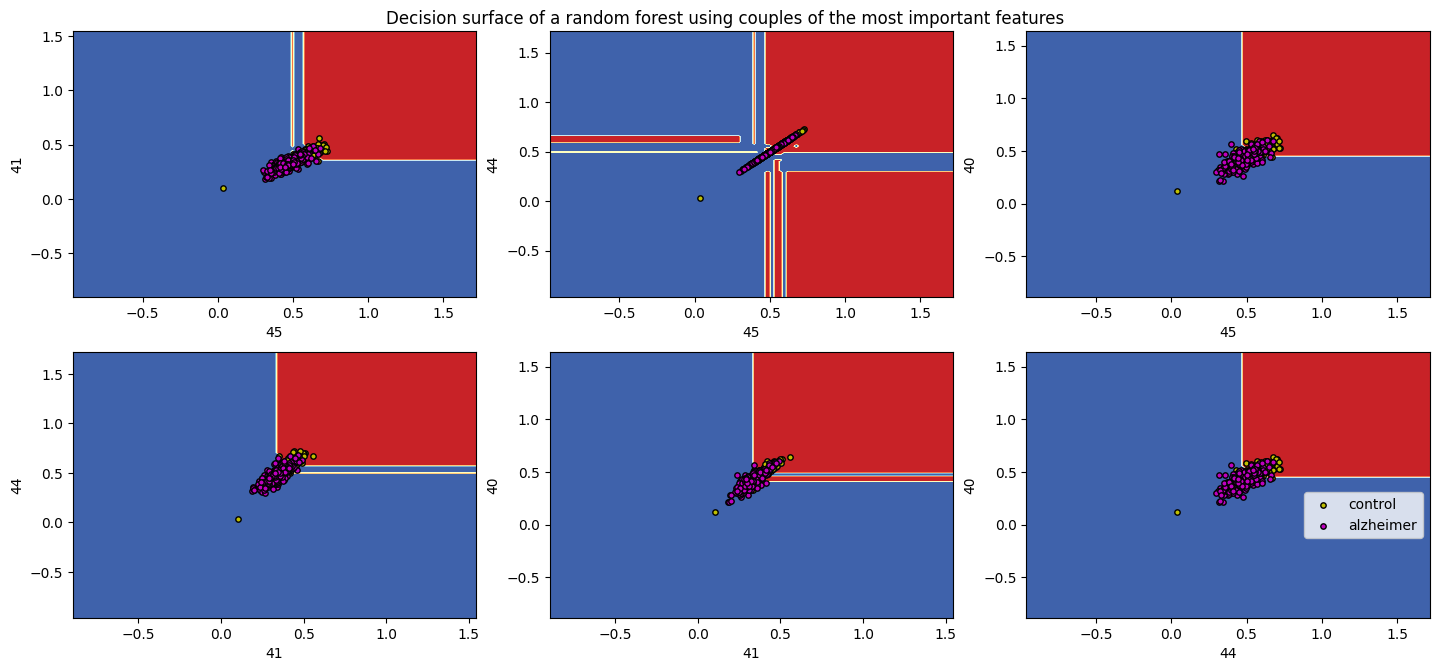

In [171]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train.ravel()

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

In [172]:
# evaluate what is the best couple of features
best_score = 0
best_pair = []
pairs = []
scores = []
for pair in [ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]:
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train.ravel()

    # Train
    clf = RF.fit(Xpair, ypair)
    score = clf.score(Xpair, ypair)
    if score > best_score:
        best_score = score
        best_pair = pair
        pairs.append(pair)
        scores.append(score)

print("Best pair of features: ", best_pair)
print("Best score: ", best_score)

Best pair of features:  [45, 41]
Best score:  0.9434276206322796


**Question**: Which is the best couple of features ?

**Answer:** As it is possible to observe above the best couple of features found is [45, 41], representing right amygdala and right hippotalamus, respectively. This result corroborates with all the results presented before. 

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

The HAMMER atlas presents a result very similar to the ALL2, renforcing the importance of the temporal lobe structures such as the hyppotalamus and the amygdalas in the early diagnosis of AD.

On the other hand, the AICHA atlas gives more importance to the parietal region of the cortical surface and to other structures such as the Thalamus and Fusiform Gyrus. 

While AD is typically associated with changes in temporal and **parietal** regions of the cortical surface, recent studies have also shown volumetric changes of other brain regions such as the **thalamus** [6]. Additionally, atrophy in temporal, parietal and frontal neocortices is associated with neuronal loss and various cognitive impairments [5]. These findings suggest that multiple brain regions should be considered when assessing AD progression. 

In fact, studies that include pathological confirmation of the diagnosis have shown that parietal atrophy combined with medial temporal lobe atrophy on MRI can accurately diagnose AD. Moreover, criteria for early detection of AD now include medial temporal atrophy, temporoparietal hypometabolism, and abnormal neuronal CSF markers, emphasizing the importance of structural imaging and other biomarkers [5]. 

Interestingly, the AICHA atlas highlights the parietal region of the cortical surface as well as other structures such as the Thalamus and Fusiform Gyrus, indicating their potential importance in AD progression, being possible candidates for biological markers. Analogously, the hyppotalamus and the amygdalas have also great potential. 

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


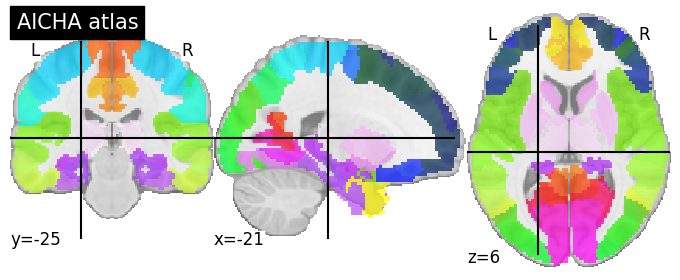

Best Validation Score: 0.7753856749311294
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 20}
Random Forest test score : 0.695364238410596
Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.060072)
2. feature 187 representing 188	N_Thalamus-5	189
 (0.054204)
3. feature 189 representing 190	N_Thalamus-7	191
 (0.027930)
4. feature 145 representing 146	S_Parietooccipital-5	147
 (0.026942)
5. feature 172 representing 173	N_Amygdala-1	174
 (0.025906)
6. feature 170 representing 171	G_Fusiform-6	172
 (0.024731)
7. feature 188 representing 189	N_Thalamus-6	190
 (0.020925)
8. feature 184 representing 185	N_Thalamus-2	186
 (0.019287)
9. feature 171 representing 172	G_Fusiform-7	173
 (0.017047)
10. feature 182 representing 183	N_Putamen-3	184
 (0.015881)


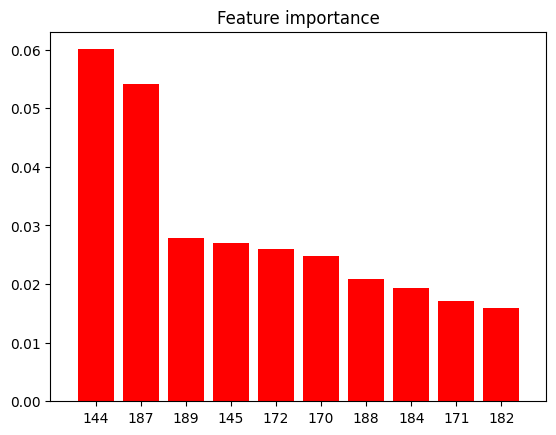

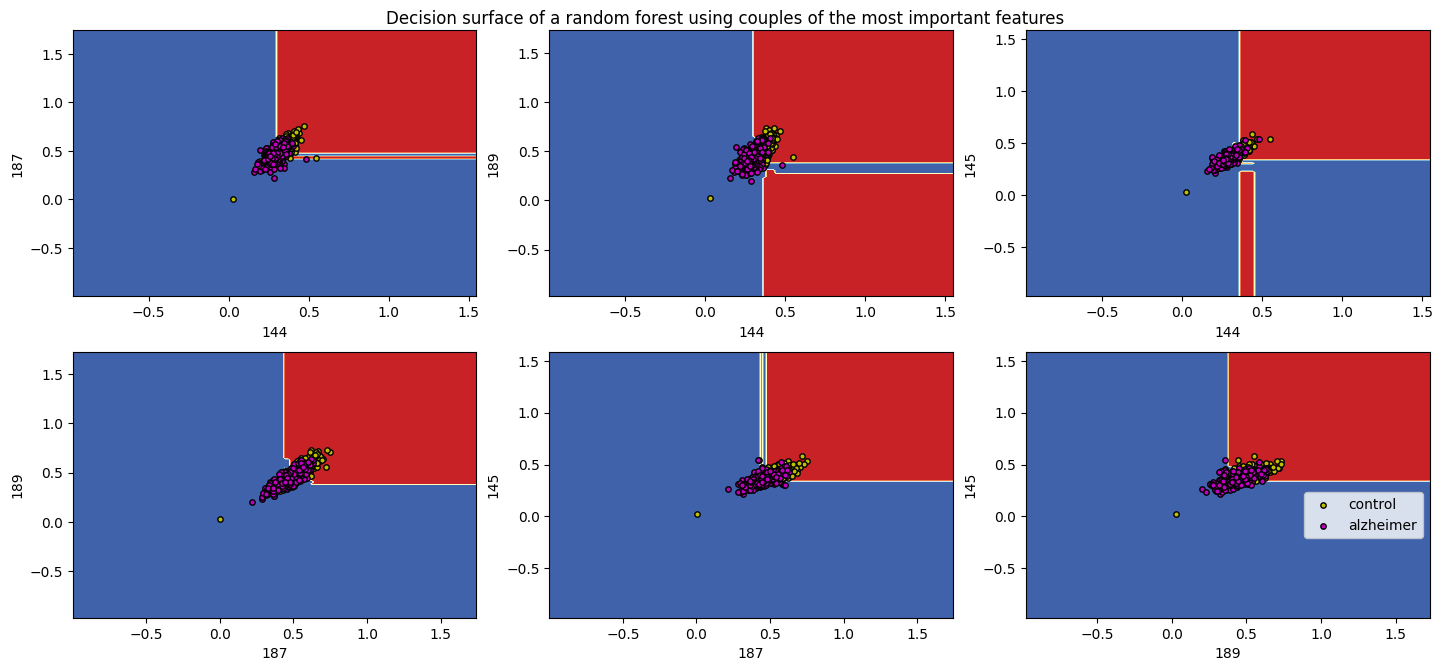

In [173]:
X=T1AICHA 
labels=ROIlabelsAICHA 
atlas='./AtlasAICHA.nii' 

N,M = X.shape 
class_names = ["control","alzheimer"]

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title='AICHA atlas')
plotting.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
scaler.fit_transform(X_train, y_train);
scaler.transform(X_test);

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, cv=5, return_train_score=True)
grid_RF.fit(X_train , y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
    
# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train.ravel()

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68


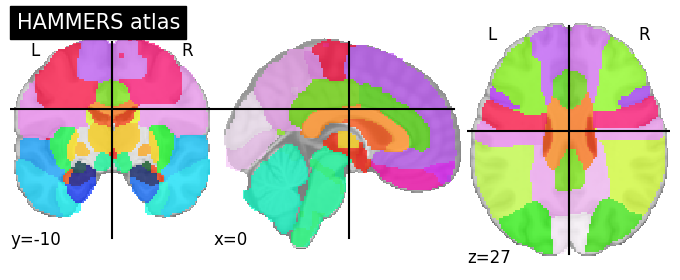

Best Validation Score: 0.8370110192837465
Best params: {'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 30}
Random Forest test score : 0.8145695364238411
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.093738)
2. feature 2 representing Left Amygdala                          (0.059521)
3. feature 0 representing Left Hippocampus                       (0.055623)
4. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.041070)
5. feature 12 representing Left Inferior Middle Temporal Gyri     (0.036867)
6. feature 46 representing Left Lateral Temporal Ventricle        (0.030330)
7. feature 5 representing Right Anterior Medial Temporal Lobe    (0.028521)
8. feature 1 representing Right Hippocampus                      (0.026373)
9. feature 4 representing Left Anterior Medial Temporal Lobe     (0.025712)
10. feature 32 representing Left Inferior Lateral Pariatal Lobe    (0.023670)


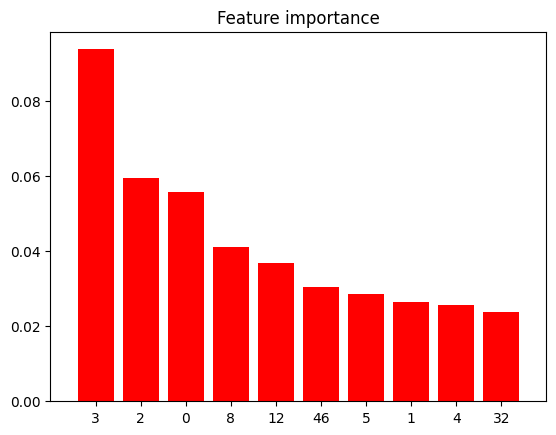

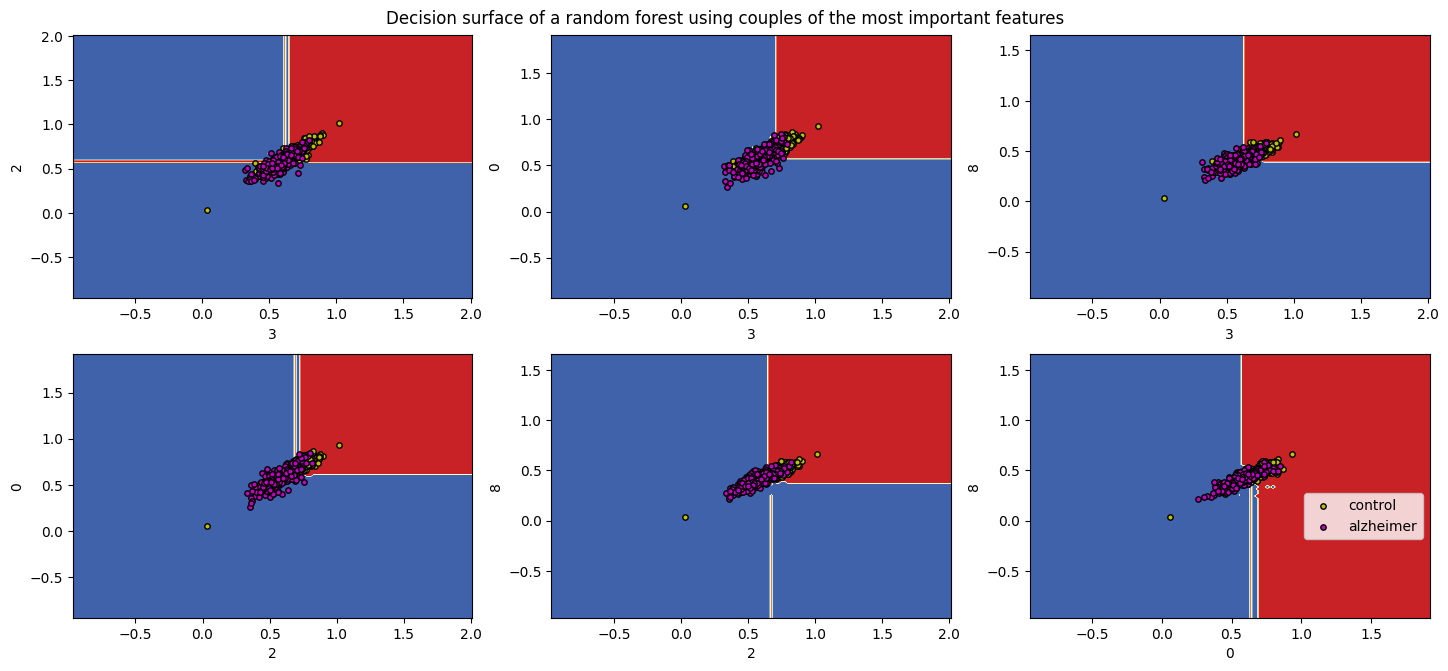

In [174]:
X=T1HAMMERS 
labels=ROIlabelsHAMMERS 
atlas='./AtlasHAMMERS.nii' 

N,M = X.shape 
class_names = ["control","alzheimer"]

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title='HAMMERS atlas')
plotting.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
scaler.fit_transform(X_train, y_train);
scaler.transform(X_test);

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, cv=5, return_train_score=True)
grid_RF.fit(X_train , y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
    
# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train.ravel()

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()